# <center> **Insurance Pricing Forecast Using XGBoost Regressor**
## Project Overview
- Objective: To build an optimized machine learning model to make accurate predictions of insurance costs based on the provided set of features. <br>

- Structure of Project:
    1. Importing Libraries
    2. Exploratory Data Analysis (EDA)
    3. Baseline Linear Model
    4. Model Building using XGBoost Regressor
    5. Comparison of models
    6. Performance of the model

---

### Importing Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

# General Lobraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import statsmodels.api as sm

# Statistical Analysis
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import chi2, f_oneway

# Data Modelling 
from sklearn.model_selection import train_test_split
from skopt.space import Real,Categorical, Integer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

print('Libraries Imported!')

Libraries Imported!


## <u> Exploratory Data Analysis (EDA) </u>

In [6]:
df = pd.read_csv('insurance.csv')

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
df.duplicated().sum()

1

Since there is one duplicated value when we should remove it.

In [11]:
df = df.drop_duplicates(keep='first')

In [12]:
df.duplicated().sum()

0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


- There are `no null values` are present in dataset.
- There are three numeric and three categorical features in the dataset.
- The variable that we want to predict is the `charges` column, so let's split the dataset into features (x) and the target (y).

In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [16]:
# Create feature variables (x) by dropping the target column.
x = df.drop('charges', axis=1)

# Create the target varible (y) by selecting the 'charges' column
y = df['charges']

In [17]:
x.shape , y.shape

((1337, 6), (1337,))

---

### Distribution Analysis

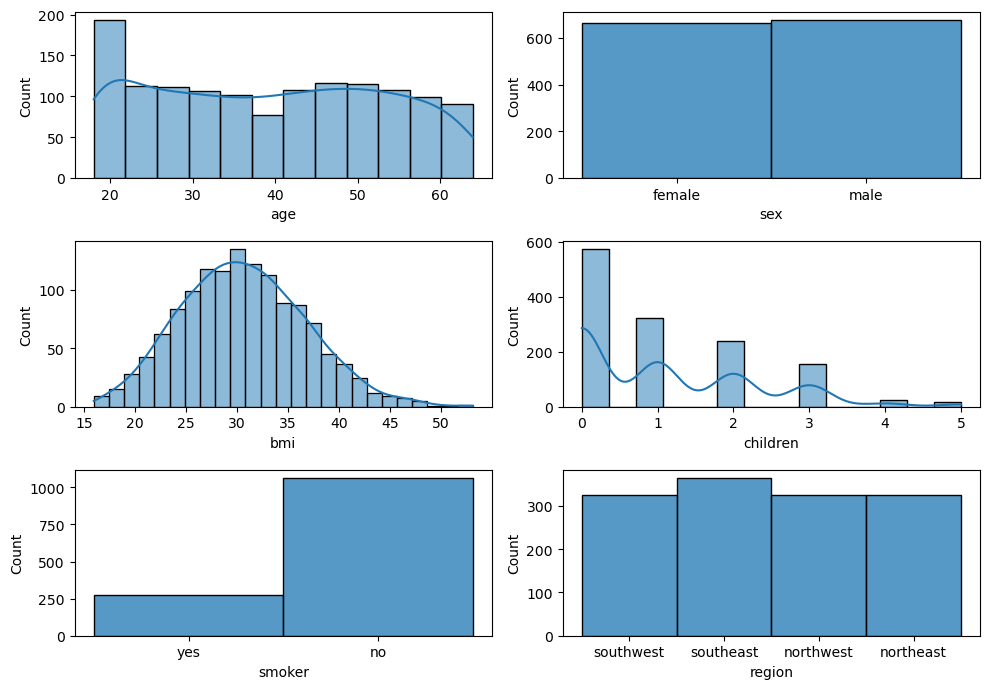

In [20]:
# Plot a histogram for each feature in x

kde_col = ['age','bmi','children']

fig, ax = plt.subplots(3, 2, figsize=(10,7))
ax = ax.flatten()

for i,col in enumerate(x.columns):
    if col in kde_col:
        sns.histplot(data = x,x=col, kde = True, ax=ax[i])
    else:
        sns.histplot(data = x,x=col, kde = False, ax=ax[i])

plt.tight_layout()
plt.show()

- Key Pointers regarding to the distribution of each feature:
    1. `age` : Approximately uniformly distributed.
    2. `sex` : Approximately equal magnitude in each category.
    3. `bmi` : Normally distributed.
    4. `children` : Right skewed (higher magnitude on the right side of curve)
    5. `smoker` : Significantly higher magnitude in the *no* category vs the *yes* category.

- Similarly the distribution of target is as follows:

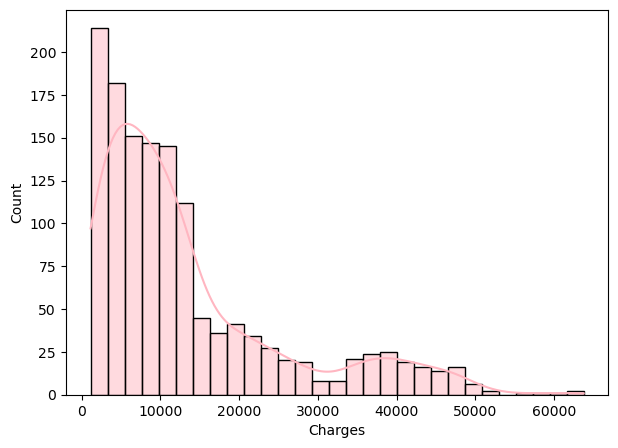

In [443]:
# Plot a histogram for the target variable

fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(data = y, kde = True, color= 'lightpink')
plt.xlabel('Charges')
plt.ylabel('Count')
plt.show()

- The disttibution is right skewed.

---

### Univariate Analysis (wrt target)

#### 1. Numeric Features

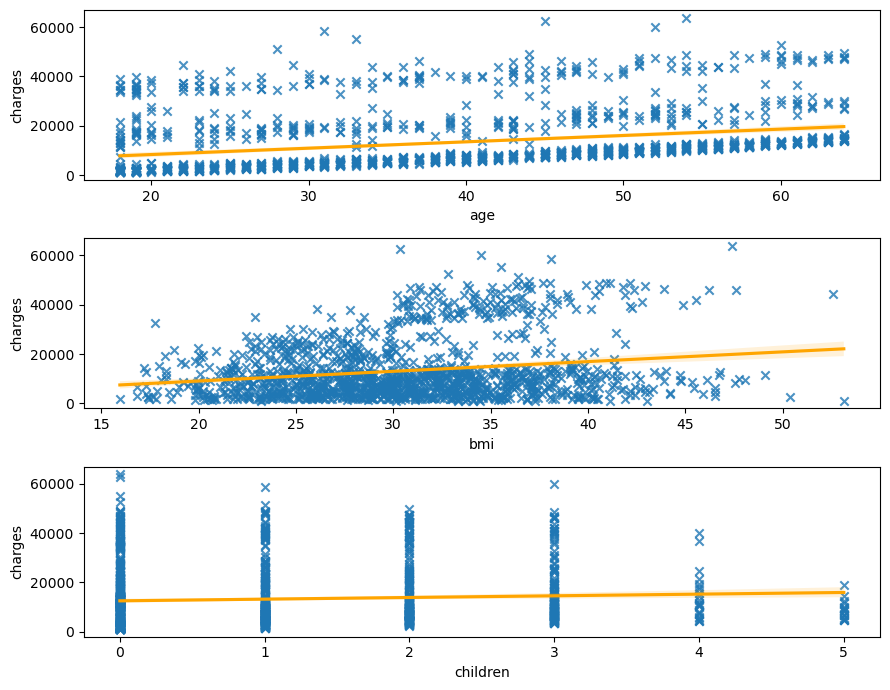

In [425]:
# Plot univariate numeric analysis for numeric features and the target variable 'y'

columns = ['age','bmi','children']

fig, ax = plt.subplots(3, 1, figsize=(9,7))
ax = ax.flatten()

for i,col in enumerate(columns):
    if col in columns:
        sns.regplot(x=col,y=y, data = x,line_kws=dict(color="orange"), marker="x", ax=ax[i])

plt.tight_layout()
plt.show()

- Key Pointers regarding feature:
    1. `age` : As the age increases, the charges also tend to increase (<u> *proportional relationship* </u>). There is a large variance in charges for an given age.
    2. `bmi` : There is <u> *no direct relationship* </u>, but there seems to be few clusters forming.
    3. `children` : <u> *No clear relationship* </u> but charges seem to decrease as children increase. However, **there are only 6 unique values for this feature, let's try to treat it as a categorical feature for the purpose of univariate analysis.**

#### 2. Categorical Features

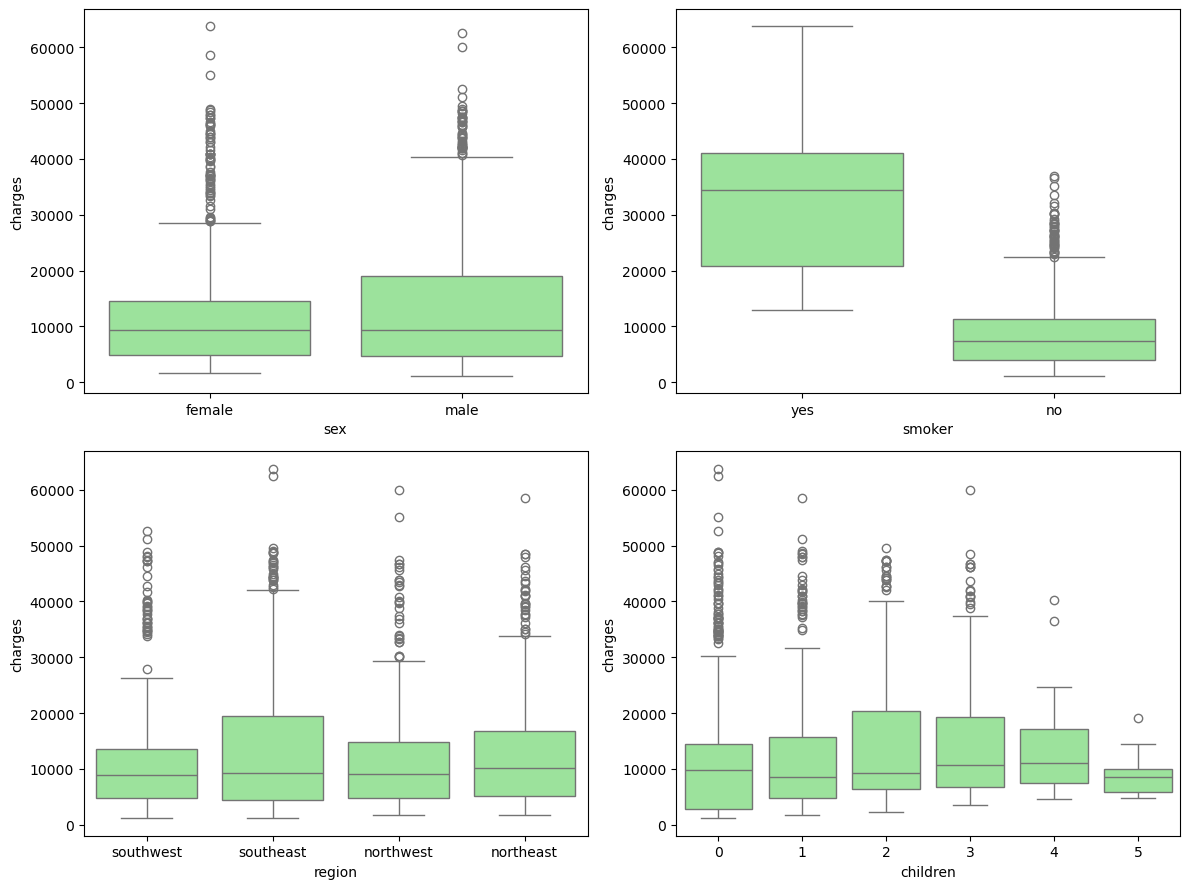

In [437]:
# Plot univariate categorical analysis for selected categorical features and the target variable 'y'

columns = ['sex', 'smoker', 'region', 'children']

fig, ax = plt.subplots(2, 2, figsize=(12,9))
ax = ax.flatten()

for i,col in enumerate(columns):
    if col in columns:
        sns.boxplot(x=col,y=y, data = x, ax=ax[i], color = 'lightgreen')

plt.tight_layout()
plt.show()

- Key Pointers regarding feature:
    1. `sex` : There is a slight difference in charges between the categories.
    2. `smoker` : Charges for smoking is higher as compared to non-smoking.
    3. `region` : No significant difference in charges among different categories.
    4. `children` : No difference in charges.

---

### Bivariate Analysis (wrt target)

#### 1. Heatmap

Here the heatmap is used to understand the correlation between variables of x.

In [495]:
# Function to plot paired heatmap plots
from itertools import combinations, product

def plot_heatmap(x, y, bins=10):
    data = pd.concat([x, y], axis=1)
    
    for num_col in x.select_dtypes(include=np.number):
        if x[num_col].nunique() >= bins:
            data[num_col] = pd.cut(data[num_col], bins=bins)
    
    col_pairs = list(combinations(x.columns, 2))

    for col1, col2 in col_pairs:
        col_pair_y_mean = data.groupby([col1, col2])[y.name].mean().reset_index()
        col_pair_y_mean = col_pair_y_mean.pivot(index=col1, columns=col2, values=y.name)

        # Plotting
        plt.figure(figsize=(9,6))
        sns.heatmap(col_pair_y_mean, annot=False, cmap="Blues")
        plt.title(f'Heatmap of {y.name} for {col1} and {col2}')
        plt.xlabel(col2)
        plt.ylabel(col1)
        plt.gca().invert_yaxis()
        plt.show()

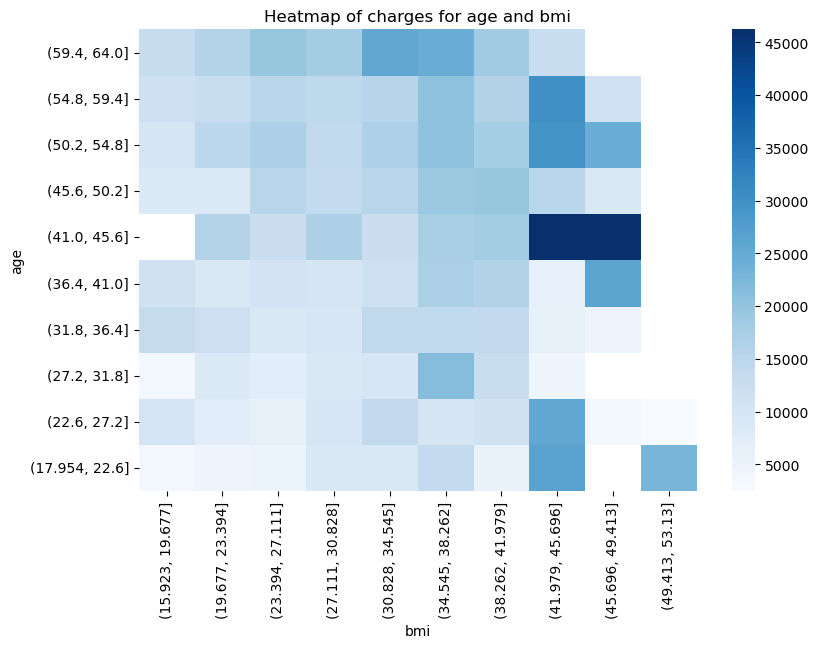

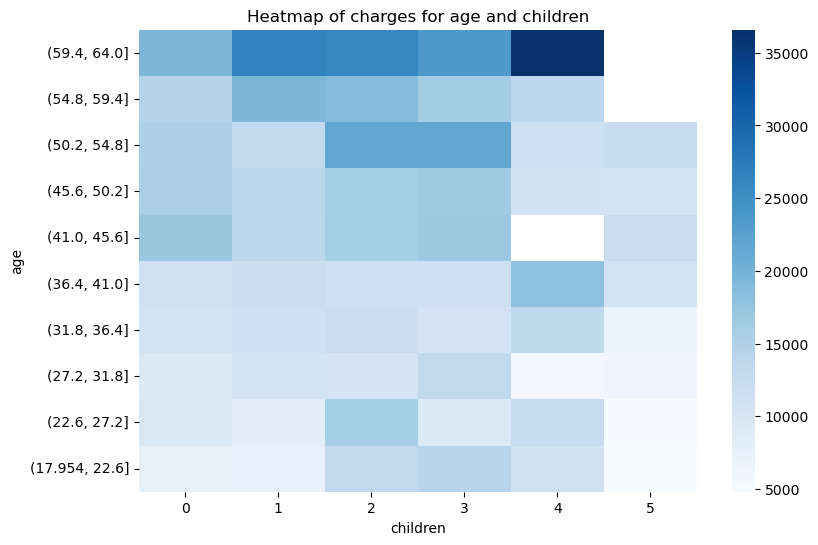

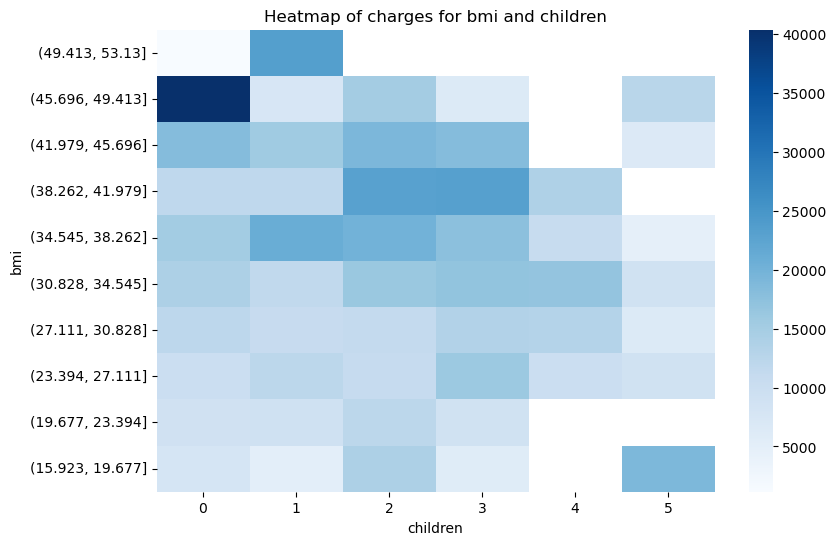

In [497]:
# Plot a heatmap for selected numeric features and the target variable 'y' with a specified number of bins

plot_heatmap(x[['age', 'bmi', 'children']], y, bins=10)

- Compared to the insights learned from the univariate analysis, these charts don't reveal anything new.

#### 2. Boxplot

In [507]:
# # Function to plot paired box plots
def plot_boxplots(X, y):
    col_pairs = list(combinations(X.columns, 2))
    
    fig, axes = plt.subplots(nrows=len(col_pairs), ncols=1, figsize=(10, len(col_pairs) * 5))
    for i, (col1, col2) in enumerate(col_pairs):
        paired_cat = col1 + '=' + X[col1] + ', ' + col2 + '=' + X[col2]
        sns.boxplot(x=paired_cat, y=y, ax=axes[i], color='lightpink')
        # axes[i].set_title(f'Boxplot for {col1} & {col2}')
        axes[i].set_xlabel(f'{col1} & {col2}')
        axes[i].set_ylabel('charges')
        axes[i].tick_params(axis='x', rotation=270)

    plt.tight_layout()
    plt.show()

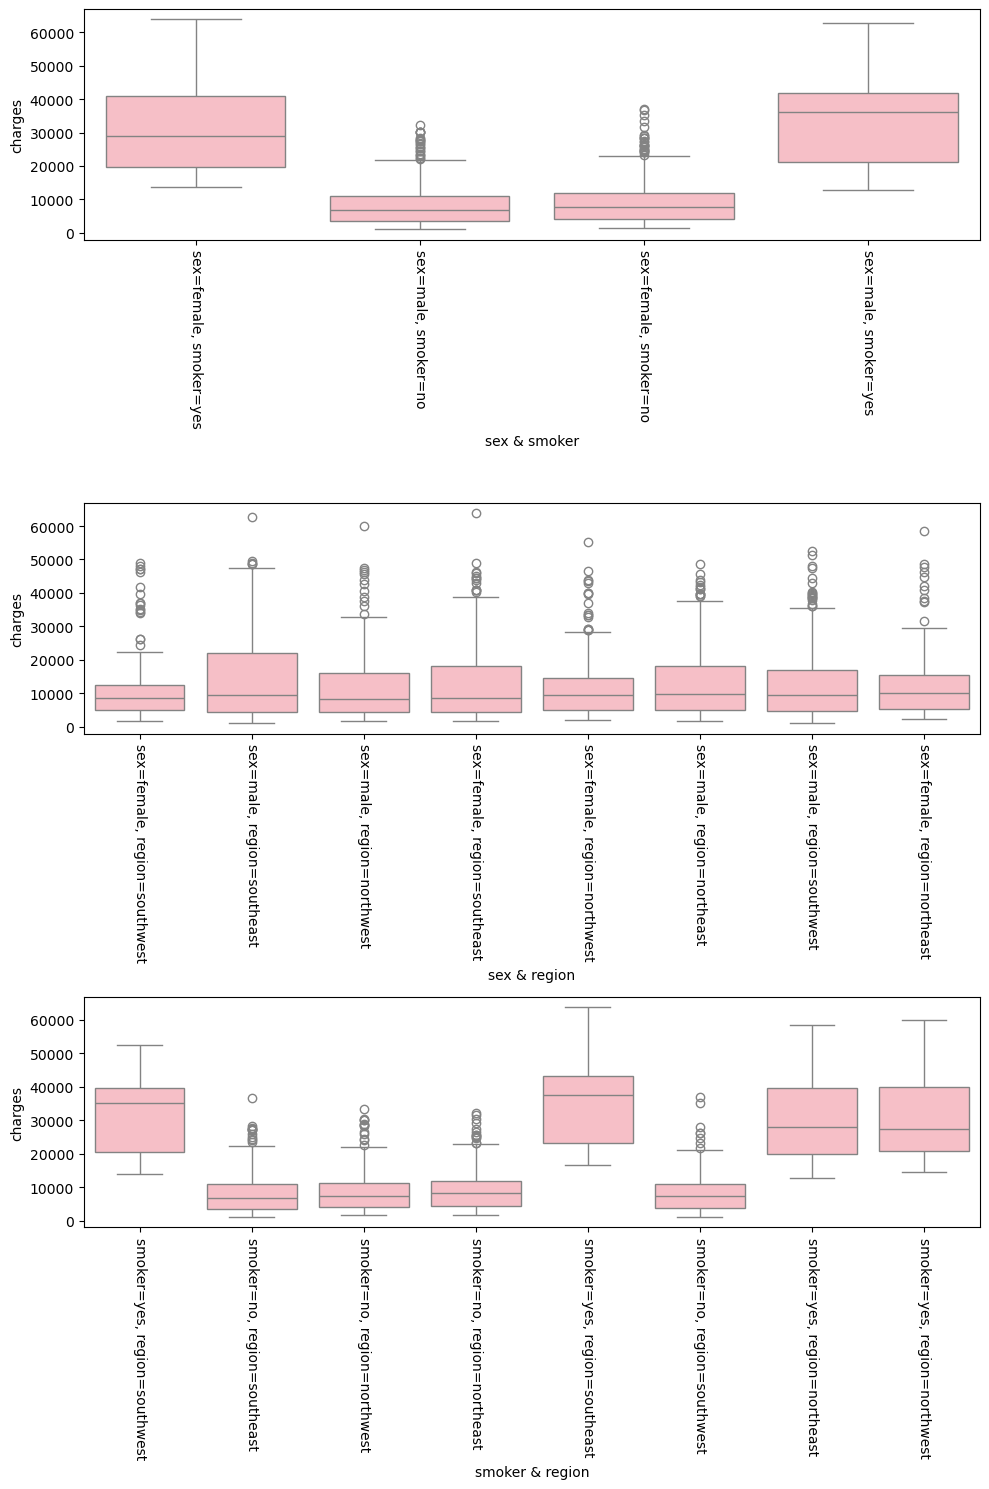

In [509]:
# Plot paired boxplots for selected categorical features and the target variable 'y'

plot_boxplots(x[['sex', 'smoker', 'region']], y)

- Key Pointers regarding feature:
  
    1. `sex` & `smoker` : The median charges are higher for males who smoke (35k) as compared to females who smoke (29k).
       
    3. `smoker` & `region` : The median charges is higher for smokers in the southeast (37k) and southwest (35k) vs the northeast (28k) and northwest (27k).

#### 3. For Numeric-categorical pairs

In [45]:
# # Function to plot paired box plots

def plot_scatterplots(x, y):
    data = pd.concat([x, y], axis=1)
    num_cols = x.select_dtypes(np.number).columns
    cat_cols = x.select_dtypes(object).columns
    col_pairs = list(product(num_cols, cat_cols))
    j = 1

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 9))
    axes = axes.flatten()
    for i, (col1, col2) in enumerate(col_pairs):
        ax = axes[i]
        for col2_val in x[col2].unique():
            mask = x[col2] == col2_val
            x_ = x[mask]
            y_ = y[mask]
            sns.scatterplot(x=x_[col1], y=y, label=col2_val, ax=ax)
        ax.set_xlabel(col1)
        ax.set_ylabel(y.name)
        ax.set_title(f'{col1} vs {y.name} by {col2}')
        ax.legend(title=col2)
        ax.grid(c = 'lightgrey')
        
    plt.tight_layout()
    plt.show()

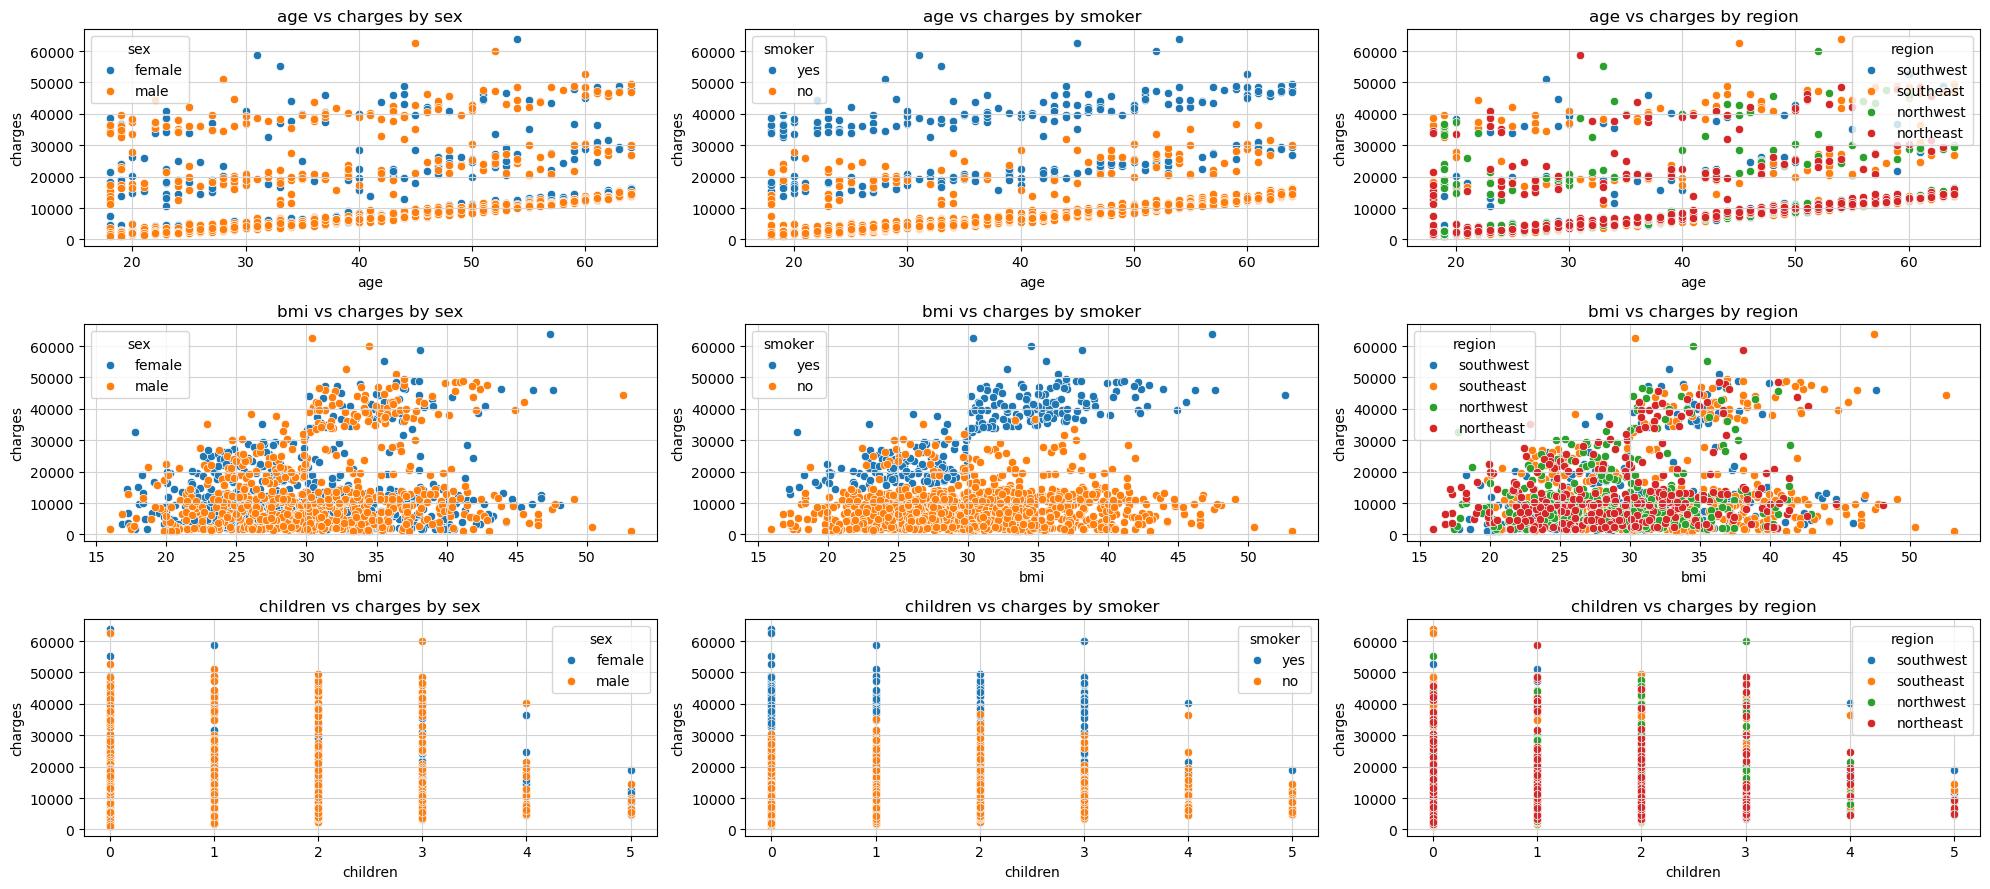

In [46]:
# Plot paired scatterplots for selected categorical features and the target variable 'y'

plot_scatterplots(x, y)

- Key Pointers regarding feature:
  1. `age`-`smoker` : There is a group in the bottom left hand quadrant of the chart (where age < 50 and smoker = 'no') where all beneficiaries have health care costs below 10k (which is relatively small compared to the rest of the population).
  2. `bmi`- `smoker`:- There is a group in the top right hand quadrant of the chart (where bmi > 30 and smoker = 'yes') where all beneficiaries have health care costs above 30k (which is relatively large compared to the rest of the population).

---

### Collinearity 

In this section collinearlity among features is explored.

#### 1. Numeric Features

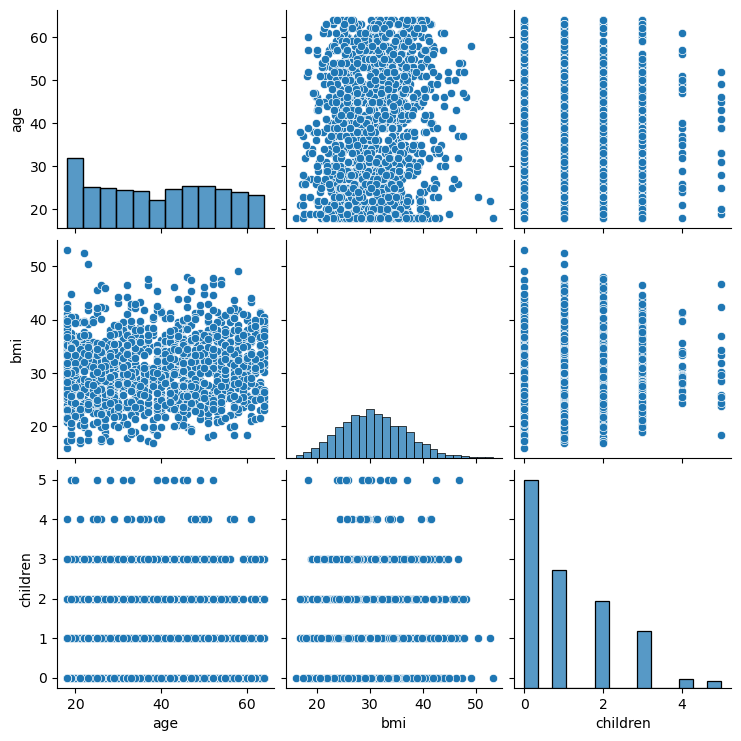

In [471]:
# Create a scatter matrix plot for numeric features
sns.pairplot(x.select_dtypes(include=np.number))
plt.show()

It can be observed that there isn't much correlation between any of the numeric features. <br> But to be sure, lets calculate and plot the **Pearson's correlation matrix**:

<Axes: >

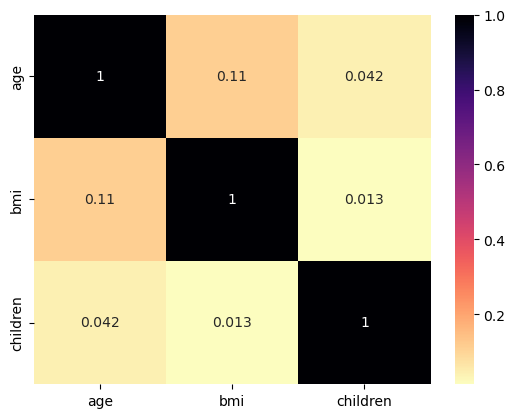

In [493]:
# Plot correlation matrix 
cmap = plt.get_cmap('magma').reversed()
sns.heatmap(x.select_dtypes(include=np.number).corr(), annot=True, cmap=cmap)

1. Little correlation between the numeric features is observed with the maximum value being **0.11**.
2. It is to be noted that the `children` column has least correlated with other numerical features.

#### 2. Categorical Features

##### <font color ='deeppink'> ***Chi-Squared Test***

In [58]:
# Function to perform chi-squared test

def chi2(x, correction=True):
    col_pairs = list(combinations(x.columns, 2))
    results_list = []
    
    for col1, col2 in col_pairs:
        contingency = pd.crosstab(x[col1],x[col2])
        
        chi2, p_val, dof, exp_freq = stats.chi2_contingency(contingency.values, correction=correction)
        
        results_list.append([col1, col2, chi2, p_val, dof])
        
    results = pd.DataFrame(results_list, columns=['column1', 'column2', 'chi_squared', 'p_value', 'dof'])
    
    return results

In [59]:
# Calculate the Pearson’s chi-sqaured test for categorical features in x 

chi2_result = chi2(x.select_dtypes(object))
chi2_result

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.469139,0.006277,1
1,sex,region,0.476910,0.923934,3
2,smoker,region,7.277903,0.063548,3


In [60]:
significant_chi2 = chi2_result[chi2_result['p_value'] < 0.05]
significant_chi2

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.469139,0.006277,1


- Key Pointers 
    1. A threshold of < 0.05 is widely accepted for rejecting the null-hypothesis (that the features are independent) since this means that there is only a 5% probability of observing the distribution by chance.
    2. On performing chi squared test on the categorical column, it is observed that only `sex` and `smoker` having the p-value of 0.006277 (which less than the threshold value of 0.05) are likely to correlated.

#### 3. Numeric-Categorical Features

##### <font color ='deeppink'> ***ANOVA***

In [64]:
# Function to perform analysis of variance (ANOVA)

def anova(x):
    num_col = x.select_dtypes(np.number).columns
    cat_col = x.select_dtypes(object).columns
    
    col_pairs = list(product(num_col, cat_col))
    results_list = []
    
    for num, cat in col_pairs:
        x_filtered_list = []
        cat_values = x[cat].unique()
        
        for cat_value in cat_values:
            x_filtered_list.append(x[x[cat] == cat_value][num].values)
            
        f_stat, p_val = stats.f_oneway(*x_filtered_list)
        results_list.append([num, cat, f_stat, p_val])
        
    results = pd.DataFrame(results_list,columns=['numerical_column', 'categorical_column', 'f_stat', 'p_value'])
    
    return results

In [65]:
anova_result = anova(x)
anova_result

,numerical_column,categorical_column,f_stat,p_value
0,age,sex,0.524296,4.691417e-01
1,age,smoker,0.874598,3.498547e-01
2,age,region,0.080765,9.704766e-01
3,bmi,sex,2.880037,8.991704e-02
4,bmi,smoker,0.018736,8.911471e-01
5,bmi,region,39.485939,1.908729e-24
6,children,sex,0.425379,5.143772e-01
7,children,smoker,0.071756,7.888386e-01
8,children,region,0.745299,5.251146e-01


In [66]:
# Find the anova test results which are less than 0.05 (threshold value)

significant_ano = anova_result[anova_result['p_value'] < 0.05]
significant_ano 

,numerical_column,categorical_column,f_stat,p_value
5,bmi,region,39.485939,1.908729e-24


- Key Pointers
    1. The above threshold of 0.05 for rejecting the null hypotheis that the columns are independent is used here as well. <br>
    2. Only `bmi` and `region` have the p-value (1.935747e-24) less than 0.05, indicating that these columns are highly co-related.

--- 

### Correlation

#### 1. Numeric Features (wrt target)

In [71]:
# Pearson correlation wrt the target variable

corr_data = df.select_dtypes(np.number).corr()
corr_data.index.name = 'features'
corr_data = corr_data.reset_index()
corr_data = corr_data[corr_data['features'] != y.name]

corr_data

,features,age,bmi,children,charges
0,age,1.000000,0.109344,0.041536,0.298308
1,bmi,0.109344,1.000000,0.012755,0.198401
2,children,0.041536,0.012755,1.000000,0.067389


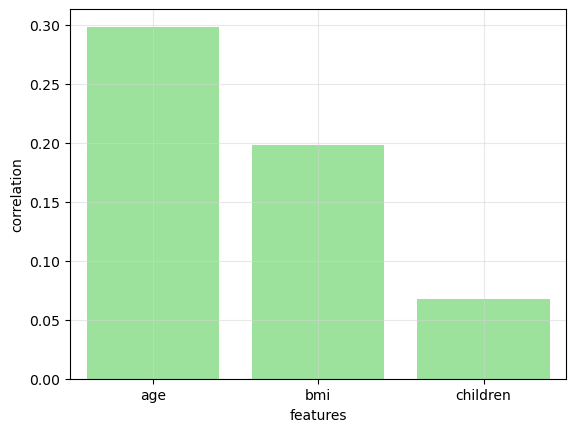

In [527]:
# Create a bar plot of Pearson correlation coefficients between numeric features and the target variable 'charges'

sns.barplot(data = corr_data, x='features', y='charges', color='lightgreen')
plt.ylabel('correlation')
plt.grid(color ='lightgrey', alpha=0.5)
plt.show()

`age` and `children` have the highest and lowest correlation with target (charges).

#### 2. Categorical Features (wrt target)

To obtain correlation between target (charges and the categorical features in x varibale we used ANOVA test.

In [76]:
anova_cat_data = anova(df)
anova_cat_data

,numerical_column,categorical_column,f_stat,p_value
0,age,sex,0.524296,4.691417e-01
1,age,smoker,0.874598,3.498547e-01
2,age,region,0.080765,9.704766e-01
3,bmi,sex,2.880037,8.991704e-02
4,bmi,smoker,0.018736,8.911471e-01
5,bmi,region,39.485939,1.908729e-24
6,children,sex,0.425379,5.143772e-01
7,children,smoker,0.071756,7.888386e-01
8,children,region,0.745299,5.251146e-01
9,charges,sex,4.513038,3.382079e-02


In [77]:
# Compute ANOVA test for categorical features wrt taget  

anova_cat_target = anova_cat_data[anova_cat_data['numerical_column'] == 'charges']
anova_cat_target

,numerical_column,categorical_column,f_stat,p_value
9,charges,sex,4.513038,3.382079e-02
10,charges,smoker,2175.736863,1.406722e-282
11,charges,region,2.926140,3.276288e-02


All the p-values corresponding to the categorical columns are less than 0.05. Implying that the differences observed in the `charges` column while comparing to categories are siginificant.

- #### **Take Home Message**
  
  1. After performing the EDA (***from correlation section***) it can be concluded that the `children` column has a low correlation to the target (charges).
     
  3. On the other hand for categorical features, from ***chi-squared test*** it is observed that `sex` and `smoker` have correlated to each other, whereas from ***ANOVA test***, it is seen that the column `region` is correlated to `bmi`.
 
  4. The features `sex` and `region` have low correlation with target (charges).

Hence these features should be removed before proceeding towards building base model.

In [80]:
X = x.drop(['sex','children','region'], axis=1)

In [81]:
X.head()

,age,bmi,smoker
0,19,27.900,yes
1,18,33.770,no
2,28,33.000,no
3,33,22.705,no
4,32,28.880,no


---

## <u> Baseline Model Building</u>

Let's start by building the baseline linear model for the data.

### Encoding

In [86]:
# Use OneHot Encoding to remove the categorical values.
X = pd.get_dummies(X, columns = ['smoker'], dtype = 'int')

In [87]:
X = X.drop('smoker_no', axis = 1)	
X.head()

,age,bmi,smoker_yes
0,19,27.900,1
1,18,33.770,0
2,28,33.000,0
3,33,22.705,0
4,32,28.880,0


### Splitting Data

In [89]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [90]:
# Check the shape of x_train and x_test
x_train.shape, x_test.shape

((895, 3), (442, 3))

In [91]:
# Check the shape of y_train and y_test
y_train.shape, y_test.shape

((895,), (442,))

In [92]:
y_train

1037    39725.51805
467     12643.37780
39      48173.36100
30      35585.57600
242     35160.13457
           ...     
1096    44641.19740
1131     3693.42800
1295     1964.78000
861      7151.09200
1127     5836.52040
Name: charges, Length: 895, dtype: float64

### Data Transformation

1. From the EDA section it is evident that the target is not normally distributed. A model trained using this target will likely produce residuals that do not have the same variance across values of the target (i.e. assumption 5 of the linear regression model will be violated).
2. Hence we transform the target column by using powertransformer.
3. Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. So whichever performs best, we will use that one.

In [95]:
# Transforming the target using  Yeo-Johnson

yj = PowerTransformer(method='yeo-johnson')
y_yeo = yj.fit_transform(y.values.reshape(-1, 1))[:, 0]

In [96]:
# Transforming the target using Box-Cox

bc = PowerTransformer(method='box-cox')
y_box = bc.fit_transform(y.values.reshape(-1, 1))[:, 0]

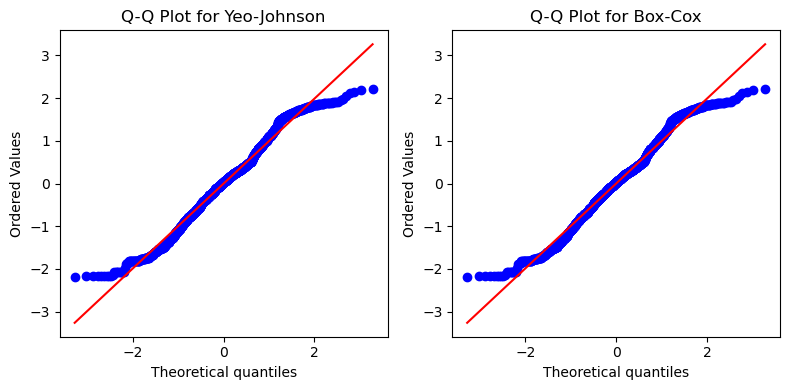

In [97]:
# Plotting QQ plot

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
    
stats.probplot(y_yeo, plot=ax[0])
ax[0].set_title('Q-Q Plot for Yeo-Johnson')

stats.probplot(y_box, plot=ax[1])
ax[1].set_title('Q-Q Plot for Box-Cox')

plt.tight_layout()
plt.show()

- Since both the transformer are working almost similarly, we will use **Box-Cox** transformer for the model.

In [99]:
# Fit and transform the training target variable
y_train_tran = bc.fit_transform(y_train.values.reshape(-1, 1))[:, 0]

# Transform the testing target variable using the same transformation
y_test_tran = bc.transform(y_test.values.reshape(-1, 1))[:, 0]

- Let's quickly check whether the transfomation had the desired effect (on both training and test sets):

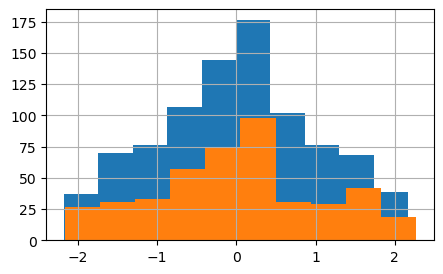

In [521]:
# Histograms for y_train and y_test

pd.Series(y_train_tran).hist(figsize=(5, 3))
pd.Series(y_test_tran).hist(figsize=(5, 3))
plt.show()

- Since the target is normalyy distributed, and the dataset is effectively analyzed we can proceed further to build the linear model using linear regression.

### Model Training

1. To improve homoscedasticity of the residuals, we can pass sample weights to the model. This ensures that when the model is trained, observations with larger `charges` are given more importance than those with smaller `charges`. *This means that residuals are penalised more heavily for the observations with larger charges vs those with smaller charges.*

2. We'll use the target column as the sample weight, but scale it by the minimum value of the charges column (so the minimum sample weight is 1):

In [105]:
# Calculate sample weights for training data
sample_weight = y_train / y_train.min() 

In [106]:
sample_weight[:5]

1037    35.409967
467     11.269874
39      42.940085
30      31.719765
242     31.340541
Name: charges, dtype: float64

In [107]:
# Training the linear model
lr = LinearRegression()

In [108]:
lr.fit(x_train, y_train_tran, sample_weight = sample_weight)

LinearRegression()

### Model Evaluation

- Now that the model is trained, we can use it to generate predictions on training and testing datasets.

In [111]:
# Make predictions on the training data
y_pred_train = lr.predict(x_train)  

# Make predictions on the test data
y_pred_test = lr.predict(x_test)    

- Since the model was trained based on a transformed version of the target, therefore we need to perform the inverse **Box-cox** transform to convert the model predictions to the original format of the target.

In [113]:
# Inverse transform the training data predictions and flatten to 1D
y_pred_train = bc.inverse_transform(y_pred_train.reshape(-1, 1))[:, 0]  

# Inverse transform the test data predictions and flatten to 1D
y_pred_test = bc.inverse_transform(y_pred_test.reshape(-1, 1))[:, 0] 

In [114]:
# y_pred_test

- #### Evalution of the model

In [116]:
# Function to calculate model performance metrics

def calc_model_performance(y, y_pred):
    results = {}
    results["Root Mean Squared Error       "] = mean_squared_error(y, y_pred, squared = False)
    results['Mean Squared Error            '] = mean_squared_error(y, y_pred)
    results['Mean Absolute Error           '] = mean_absolute_error(y, y_pred)
    results['Mean Absolute Percentage Error'] = mean_absolute_percentage_error(y, y_pred)*100 
    results['R-Squared                     '] = r2_score(y, y_pred)
    
    return results

In [117]:
# Calculate the model performance on the training data
base_perf_train = calc_model_performance(y_train, y_pred_train) 

# Calculate the model performance on the test data
base_perf_test = calc_model_performance(y_test, y_pred_test) 

In [118]:
base_perf_train

{'Root Mean Squared Error       ': 5875.3806927787355,
 'Mean Squared Error            ': 34520098.28507713,
 'Mean Absolute Error           ': 4585.074483131735,
 'Mean Absolute Percentage Error': 75.01903681994882,
 'R-Squared                     ': 0.7437503428604261}

In [119]:
base_perf_test

{'Root Mean Squared Error       ': 5830.098231674942,
 'Mean Squared Error            ': 33990045.39097929,
 'Mean Absolute Error           ': 4423.769050949412,
 'Mean Absolute Percentage Error': 72.31595625355367,
 'R-Squared                     ': 0.8001766829267943}

For the training set the RMSE is around 5875 where as for the test set the RMSE is 5830, these are numbers should be imporved.

- #### Residuals

Let's check whether the residuals for training and test set are normally distributed or not.. 

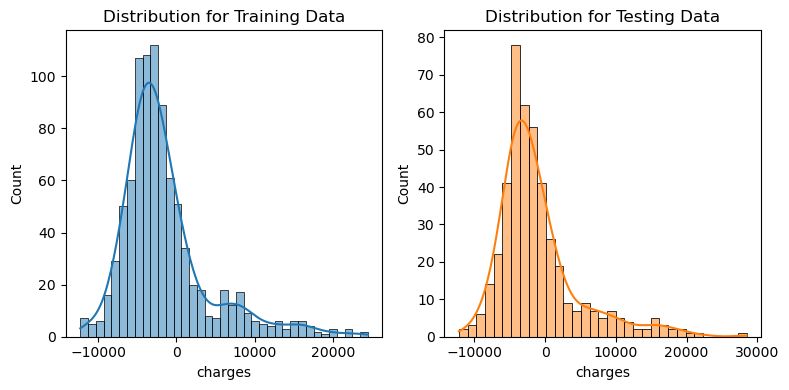

In [123]:
# Calculate Residual for training and testing data
residual_train = y_train - y_pred_train
residual_test = y_test - y_pred_test

# Distribution for training and test set
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
    
sns.histplot(residual_train, kde=True, ax=ax[0])
ax[0].set_title('Distribution for Training Data')

sns.histplot(residual_test, kde=True, ax=ax[1], color = '#ff7f0e')
ax[1].set_title('Distribution for Testing Data')

plt.tight_layout()
plt.show()

- The residuals are not perfectly normally distributed, but are pretty close.

> #### Homoscedasticity

We can check for homoscedasticity using a scatterplot, where the target is shown along the x-axis and the residuals are shown along the y-axis. We would expect the datapoints to be equally distributed across the y-axis as x (i.e. the target value) increases.

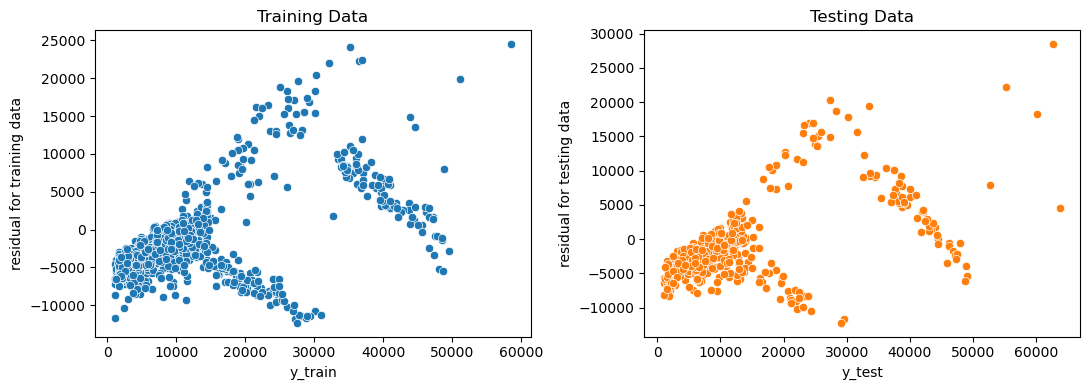

In [127]:
 # Plot a scatter plot of residuals

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax = ax.flatten()
    
sns.scatterplot(x=y_train, y = residual_train, ax=ax[0])
ax[0].set_title('Training Data')
ax[0].set_xlabel('y_train')
ax[0].set_ylabel('residual for training data')


sns.scatterplot(x=y_test, y = residual_test, ax=ax[1], color = '#ff7f0e')
ax[1].set_title('Testing Data')
ax[1].set_xlabel('y_test')
ax[1].set_ylabel('residual for testing data')

plt.tight_layout()
plt.show()

- The model exhibits significant heteroscedasticity (i.e. the variance of the residuals is not homogeneous with respect to the target).
- Since this is a baseline model, we will not spend additional time attempting to improve this.

---

## <u> Model Building using XGBoost Regressor</u>

### Data Processing

- For the baseline linear model, the dataset was manually optimized. Thus to optimize the training process we will create a new training and testing sets.

In [133]:
X = pd.get_dummies(x, dtype = 'int')

In [134]:
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


In [135]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [136]:
y_train

1037    39725.51805
467     12643.37780
39      48173.36100
30      35585.57600
242     35160.13457
           ...     
1096    44641.19740
1131     3693.42800
1295     1964.78000
861      7151.09200
1127     5836.52040
Name: charges, Length: 895, dtype: float64

In [137]:
x_train.shape, y_train.shape

((895, 11), (895,))

In [138]:
x_test.shape, y_test.shape

((442, 11), (442,))

### Using Sklearn's Pipeline 

- In this section, we will use `XGBoost Regressor` algorithm as well as `BayesSearchCV` to optimize the model training process.
- The XGBoost algorithm has a number of parameters that can affect the predictive performance of the model. Rather than trying to optimise these parameters manually, we can leverage Sklearn's Pipeline class, along with Skopt's `BayesSearchCV` class, to optimise them automatically.
- We'll also use `Recursive Feature Elimination (RFE)` in this process to optimise the features that are used by the final XGBoost model.


In [141]:
# Create a Recursive Feature Elimination (RFE) object with XGB Regressor as the estimator
rfe = RFE(estimator = XGBRegressor())
print('done!')

done!


In [142]:
# Create a XGBoost Regressor
xgb = XGBRegressor()
print('done!')

done!


- Now we create our pipeline by specifying the list of sequential processes we want to run.
- The output of each step is passed to the next, with the final step being an estimator (i.e. model). In this case, we want to:
    1. Apply feature selection via RFE.
    2. Train the XGBoost regressor.
- We do this by creating a list of tuples, where the first element of each tuple is a label for the step, and the second element is the class to run:

In [144]:
# Define a list of steps for a processing pipeline
# Step 1. RFE
# Step 2. XGB Regressor

steps = [('rfe', rfe), 
         ('xgb', xgb)]

In [145]:
steps

[('rfe',
  RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device=None,
                             early_stopping_rounds=None, enable_categorical=False,
                             eval_metric=None, feature_types=None, gamma=None,
                             grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=None, n_jobs=None,
                             num_parallel_tree=None, rando

- Passing this to `Pipeline` class.

In [147]:
# Create a pipeline 
pipe = Pipeline(steps)

In [148]:
pipe

Pipeline(steps=[('rfe',
                 RFE(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

- When the `fit` method of the pipeline is called, it will pass the features and target to the `RFE fit_transform` method.
- The output of this will be passed to the `fit method` of the `XGBoost regressor`.
- Now that we have our pipeline defined, we can set up our `BayesSearchCV` class to optimise the parameters of the pipeline.
- Firstly, we need to define the parameters we want to optimise and the space over which the BayesSearchCV should search.
- Note that since we're using a pipeline, we need to define the parameters related to each step by adding a prefix, which is the step's label and two underscores (e.g. xgb__ for the XGBoost step):

In [150]:
# Compute the number of features in x_train
num_features = x_train.shape[1]
num_features

11

In [151]:
# Search space for hyperparameters

search_space = {
    'rfe__n_features_to_select': Integer(1, num_features),  # Number of features selected by RFE
    
    'xgb__n_estimators': Integer(1, 500),                   # Number of trees in XGBoost

    'xgb__max_depth': Integer(2, 8),                        # Maximum depth of trees in XGBoost

    'xgb__reg_lambda': Integer(1, 200),                     # Regularization term (lambda) in XGBoost

    'xgb__learning_rate': Real(0, 1),                       # Learning rate in XGBoost
    
    'xgb__gamma': Real(0, 2000)                             # Gamma parameter in XGBoost
}
print('done')

done


- Once the search space for each parameter is defined, we pass this and our pipeline to the `BayesSearchCV` class.

In [153]:
#  Create a BayesSearchCV object for hyperparameter optimization
xgb_bs_cv = BayesSearchCV(
    estimator=pipe,                                       # Pipeline with RFE and XGBoost
    search_spaces=search_space,                          # Search spaces for hyperparameters
    scoring='neg_root_mean_squared_error',                # Scoring metric (negative RMSE)
    n_iter=75,                                            # Number of optimization iterations
    cv=3,                                                 # Number of cross-validation folds
    n_jobs=-1,                                            # Utilize all available CPU cores
    verbose=1,                                            # Display optimization progress
    random_state=0                                        # Ensure reproducibility
)

- Now we can initiate the parameter optimization process using our training set.

In [155]:
# Fit the BayesSearchCV to the training data
xgb_bs_cv.fit(x_train, y_train)
print('Done Training!')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

#### Model Evaluation 

In [157]:
bayes_results = pd.DataFrame(xgb_bs_cv.cv_results_).sort_values('rank_test_score')

In [158]:
bayes_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.784745,0.072917,0.007480,0.006420,6,190.851277,0.221272,3,24,12,"{'rfe__n_features_to_select': 6, 'xgb__gamma':...",-4565.615886,-4518.729372,-4435.879504,-4506.741587,53.638683,1
38,0.777278,0.024394,0.003996,0.004467,7,1896.36798,0.24902,3,36,25,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4585.261627,-4553.440575,-4447.782738,-4528.828314,58.761857,2
56,0.777636,0.031185,0.004904,0.002143,7,878.891779,0.224246,2,27,1,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4625.688284,-4439.149667,-4523.301241,-4529.379731,76.275269,3
47,0.675381,0.014488,0.007866,0.002130,8,187.614441,0.253217,2,91,58,"{'rfe__n_features_to_select': 8, 'xgb__gamma':...",-4649.788787,-4472.166983,-4482.784099,-4534.913290,81.344804,4
20,1.000799,0.027168,0.009482,0.001059,6,191.423072,0.221903,3,75,42,"{'rfe__n_features_to_select': 6, 'xgb__gamma':...",-4640.006798,-4509.204657,-4462.496903,-4537.236119,75.129944,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,1.663016,0.025497,0.009216,0.004822,1,1539.470569,1.0,2,395,130,"{'rfe__n_features_to_select': 1, 'xgb__gamma':...",-7498.082071,-7542.658468,-7176.201945,-7405.647495,163.259934,71
13,0.576648,0.026309,0.003825,0.001602,8,0.0,0.716345,2,1,47,"{'rfe__n_features_to_select': 8, 'xgb__gamma':...",-8077.519232,-7505.457763,-7983.309303,-7855.428766,250.437823,72
21,0.845219,0.049545,0.003738,0.005287,6,224.121055,0.016859,3,23,30,"{'rfe__n_features_to_select': 6, 'xgb__gamma':...",-9550.792449,-8911.342481,-9526.233078,-9329.456003,295.820867,73
25,0.802756,0.038434,0.005609,0.002681,6,188.835795,0.229943,4,1,51,"{'rfe__n_features_to_select': 6, 'xgb__gamma':...",-10532.278805,-9792.947285,-10479.344477,-10268.190189,336.741616,74


- Let's make predictions on our training and testing data sets using the model trained with our best performing parameters.`

In [160]:
# Make predictions on the training data using the XGBoost model from BayesSearchCV
y_pred_train_xgb = xgb_bs_cv.predict(x_train)

# Make predictions on the testing data using the XGBoost model from BayesSearchCV
y_pred_test_xgb = xgb_bs_cv.predict(x_test)

In [161]:
# Calculate the performance metrics for the testing data predictions using a custom function
xgb_perf_train = calc_model_performance(y_train, y_pred_train_xgb)

In [162]:
xgb_perf_train

{'Root Mean Squared Error       ': 4138.215116573434,
 'Mean Squared Error            ': 17124824.351036876,
 'Mean Absolute Error           ': 2298.020614445618,
 'Mean Absolute Percentage Error': 28.60491081035291,
 'R-Squared                     ': 0.8728789723514305}

In [163]:
# Calculate the performance metrics for the testing data predictions using a custom function
xgb_perf_test = calc_model_performance(y_test, y_pred_test_xgb)

In [164]:
xgb_perf_test

{'Root Mean Squared Error       ': 4627.110297923173,
 'Mean Squared Error            ': 21410149.70914667,
 'Mean Absolute Error           ': 2568.2664619505085,
 'Mean Absolute Percentage Error': 29.481783674039946,
 'R-Squared                     ': 0.874132350083562}

---

## <u> Comparison of models</u>

Let's compare the baseline linear model and the xgboost model, to decide which one is more optimized and should be used for forecasting.

In [167]:
def compare_model_performance(base_perf, new_perf):
    results = pd.DataFrame(columns=['base', 'new', 'abs_improvement', 'percent_improvement'])
    for metric, base_value in base_perf.items():
        base_value = round(base_value, 2)
        new_value = round(new_perf[metric], 2)
        results.loc[metric] = [
            base_value, new_value, abs(new_value - base_value), abs(round(100 * (new_value - base_value) / base_value, 2))
        ]
    return results

In [168]:
# Compare model performance for training data
performance_comp_train = compare_model_performance(base_perf_train, xgb_perf_train)

# Compare model performance for testing data
performance_comp_test = compare_model_performance(base_perf_test, xgb_perf_test)

In [169]:
performance_comp_train

,base,new,abs_improvement,percent_improvement
Root Mean Squared Error,5875.38,4138.22,1737.16,29.57
Mean Squared Error,34520098.29,17124824.35,17395273.94,50.39
Mean Absolute Error,4585.07,2298.02,2287.05,49.88
Mean Absolute Percentage Error,75.02,28.60,46.42,61.88
R-Squared,0.74,0.87,0.13,17.57


In [289]:
performance_comp_test

,base,new,abs_improvement,percent_improvement
Root Mean Squared Error,5830.10,4627.11,1202.99,20.63
Mean Squared Error,33990045.39,21410149.71,12579895.68,37.01
Mean Absolute Error,4423.77,2568.27,1855.50,41.94
Mean Absolute Percentage Error,72.32,29.48,42.84,59.24
R-Squared,0.80,0.87,0.07,8.75


- ### Take Home Message
  1. **There is a significant decrease in all the errors values and increase $R^2$ value from baseline model to improved model for both training and testing sets.**
  4. From the baseline to the xgb model, there was a **20.63%** improvement in the **RMSE** value for the test set.
  5. The  **$R^2$** value for test set has improved by **8.75%** from baseline to xgb model.
  6. The obtained results indicate that the **XGBoost Regressor model is the optimized model** and can be used for price forecasting.

---

## <u> Performance of the model</u>

To explain the performance of the selected model in simplified terms we will analyze few metrics.

- What percentage of the model's predictions are within a certain range of the actual `charges` value.


In [314]:
# Function to calculate the percentage of predictions within a specified residual range
# range = The specified residual range for which predictions are calculated

def calc_preds_in_residual_range(y_true, y_pred, range_):
    residuals = abs(y_true - y_pred)
    return 100 * (residuals <= range_).mean()

In [316]:
# Calculate the percentage of our model's predictions (on the test set) that are within $2000 of the actual charges value is

calc_preds_in_residual_range(y_true=y_test, y_pred=y_pred_test_xgb, range_=2000)

70.58823529411765

- What percentage of our model's predictions are within a certain percentage of the actual `charges` value.

In [324]:
# Function to calculate the percentage of predictions within a specified percentage residual range

def calc_preds_in_residual_perc_range(y_true, y_pred, perc_range):
    perc_residuals = 100 * (abs(y_true - y_pred) / y_true)
    return 100 * (perc_residuals <= perc_range).mean()

In [326]:
# Calculate the percentage our model's predictions (on the test set) that are within 20% of the actual charges value is:

calc_preds_in_residual_perc_range(y_true=y_test, y_pred=y_pred_test_xgb, perc_range=20)

54.97737556561086

---